In [1]:
import pandas as pd
import numpy as np
import math
import time
import matplotlib.pyplot as plt
import seaborn as sns
import autograd.numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV 
from skopt import BayesSearchCV
from sklearn.metrics import mean_absolute_error
from gc_aux import r2_score, plot_learning_curve_with_vt_set, plot_learning_curve
from skopt import gp_minimize
from skopt.space import Real, Categorical, Integer
from skopt.utils import use_named_args
from skopt.plots import plot_convergence, plot_objective, plot_evaluations
from pandas.plotting import scatter_matrix
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import StandardScaler

In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='lightgbm')

In [326]:
df_raw = pd.read_excel('data/new_excels/Vc.xlsx')

In [327]:
df_raw['Const_Value'] = df_raw['Const_Value']*1000

In [328]:
df_train, df_val_test = train_test_split(df_raw, test_size=0.4, random_state=250)

prop_tag = 'Vc'

In [329]:
from sklearn.utils import shuffle

#re splitting the train and val/test set
total_rows = len(df_train) + len(df_val_test)
target_rows_80 = int(total_rows * 0.8)
target_rows_85 = int(total_rows * 0.85)
target_rows_90 = int(total_rows * 0.9)
target_rows_95 = int(total_rows * 0.95)

def split_datasets(df_train, df_val_test, target_rows):
    df_val_test_randomized = shuffle(df_val_test, random_state=0)
    
    rows_to_transfer = target_rows - len(df_train)
    
    df_train_new = pd.concat([df_train, df_val_test_randomized.iloc[:rows_to_transfer]])
    df_val_test_new = df_val_test_randomized.iloc[rows_to_transfer:]
    
    return df_train_new, df_val_test_new

df_train_80, df_val_test_80 = split_datasets(df_train, df_val_test, target_rows_80)
df_train_85, df_val_test_85 = split_datasets(df_train, df_val_test, target_rows_85)
df_train_90, df_val_test_90 = split_datasets(df_train, df_val_test, target_rows_90)
df_train_95, df_val_test_95 = split_datasets(df_train, df_val_test, target_rows_95)

In [330]:
smiles_list = ['O=CO', 'FCC(F)(F)F', 'Cc1ccccc1OP(=O)(Oc1ccccc1C)Oc1ccccc1C', 
               'O=C(O)C1=C[C@H](O)[C@@H](O)[C@@H](O[C@@H]2[C@H](O)[C@@H](O)C(O)O[C@@H]2C(=O)O)O1',
              'CCOS(=O)(=O)O', 'Cc1cccc2c1sc1c(C)cccc12']
len_move = len(smiles_list)

df_to_move = df_val_test_80[df_val_test_80['SMILES'].isin(smiles_list)]
row_to_move = df_train_80.iloc[[-len_move]]

df_train_80 = df_train_80.drop(row_to_move.index)
df_train_80 = pd.concat([df_train_80, df_to_move], ignore_index=True)

df_val_test_80 = df_val_test_80[~df_val_test_80['SMILES'].isin(smiles_list)]
df_val_test_80 = pd.concat([df_val_test_80, row_to_move], ignore_index=True)

df_train_80.to_csv('data/df_train_95.csv', index=False)

preparing the entire set 

In [331]:
# extract G
# df_grp_raw = df_raw.loc[:,'Group 1':]
df_grp_raw = df_raw.loc[:,'CH3':]
df_grp_raw = df_grp_raw.iloc[:,:220+130+74]
# G = df_grp_raw.loc[:, (df_raw != 0).any(axis=0)].to_numpy()
G = df_grp_raw.to_numpy()

# extract y
# df_target_raw = df_raw['Tc']
df_target_raw = df_raw['Const_Value']
y = df_target_raw.to_numpy()

In [332]:
# #if randomly splitting
# G_train, G_test, y_train, y_test = train_test_split(G, y, test_size=0.2, random_state=42)
# G_train, G_val, y_train, y_val = train_test_split(G_train, y_train, test_size=0.25, random_state=42)

preparing the training set

In [333]:
df_train = df_train_80

# extract target values
df_target = df_train['Const_Value']
# extract all groups
df_grp = df_train.loc[:,'CH3':]
df_grp = df_grp.iloc[:,:220+130+74]
# df_grp = df_raw[df_raw.columns[2:]]

# extract G
# G_train = df_grp.loc[:, (df_raw != 0).any(axis=0)].to_numpy()
G_train = df_grp.to_numpy()
# sog_train = G_train[:,nr_fog:nr_fog+nr_sog]
# tog_train = G_train[:,nr_fog+nr_sog:]
# extract y
y_train = df_target.to_numpy()

preparing the validation and test set

In [334]:
df_val_test = df_val_test_80

# extract target values
df_vt_target = df_val_test['Const_Value']
# extract all groups
df_vt_grp = df_val_test.loc[:,'CH3':]
df_vt_grp = df_vt_grp.iloc[:,:220+130+74]

# extract G
# G_vt = df_vt_grp.loc[:, (df_grp != 0).any(axis=0)].to_numpy()
G_vt = df_vt_grp.to_numpy()
# sog_vt = G_vt[:,nr_fog:nr_fog+nr_sog]
# tog_vt = G_vt[:,nr_fog+nr_sog:]
# extract y
y_vt_fog = df_vt_target.to_numpy()
#splitting the validation, test set

G_val, G_test, y_val, y_test = train_test_split(G_vt, y_vt_fog, test_size=0.5, random_state=42)

fitting with all the groups

In [335]:
#define the scaler
scaler_rf = StandardScaler()
#fit the scaler
scaler_rf.fit(y.reshape(-1, 1))
#apply scaler
ys_train = scaler_rf.transform(y_train.reshape(-1, 1)).reshape(y_train.size,)
ys_val = scaler_rf.transform(y_val.reshape(-1, 1)).reshape(y_val.size,)
ys_test = scaler_rf.transform(y_test.reshape(-1, 1)).reshape(y_test.size,)

In [336]:
lgbm = lgb.LGBMRegressor(
    boosting_type='dart',
    force_col_wise=True,
#     bagging_fraction=0.9,
#     bagging_freq=1,
#     feature_fraction=0.9,
    verbose=-1
)

lgbm.fit(G_train, ys_train)

# #if early stopping (early stopping not avaiable in dart)
# lgbm.fit(G_train, ys_train, eval_set=[(G_val, ys_val)], callbacks=[lgb.early_stopping(stopping_rounds=5)], eval_metric='mae')

LGBMRegressor(boosting_type='dart', force_col_wise=True, verbose=-1)

In [337]:
y_pred_test_0 = lgbm.predict(G_test)
y_pred_test_0 = scaler_rf.inverse_transform(y_pred_test_0.reshape(-1, 1)).reshape(y_pred_test_0.size)

print('MAE:', mean_absolute_error(y_test, y_pred_test_0))
print('R2 score', r2_score(y_test, y_pred_test_0))

MAE: 64.9753714906836
R2 score 0.9057863280659862


In [338]:
st = time.time()

param_grid = {
    'min_child_samples': np.arange(1, 5),
}

grid_search = GridSearchCV(
    estimator=lgbm,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=5,
    verbose=1
)

grid_search.fit(G_val, ys_val)
end = time.time()

print('best params are', grid_search.best_params_)
print('best mae is', -grid_search.best_score_)
print('Time:', end-st)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
best params are {'min_child_samples': 3}
best mae is 0.2757386137522364
Time: 0.8609466552734375


Fitting 5 folds for each of 51 candidates, totalling 255 fits
best params are {'reg_lambda': 0.08}
best mae is 0.4605277148693362
Time: 3.171999454498291


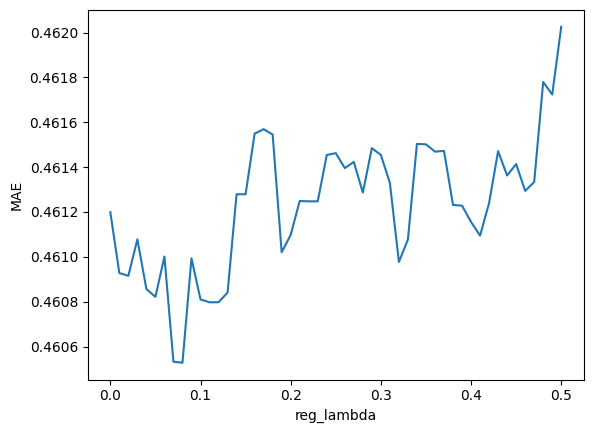

In [339]:
st = time.time()

param_grid = {
    'reg_lambda': np.arange(0, 0.51, 0.01) 
}

grid_search = GridSearchCV(
    estimator=lgbm,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=5,
    verbose=1
)

grid_search.fit(G_val, ys_val)
end = time.time()

print('best params are', grid_search.best_params_)
print('best mae is', -grid_search.best_score_)
print('Time:', end-st)

results = grid_search.cv_results_
gamma = results['param_reg_lambda']
mean_test_scores = -results['mean_test_score'] 

plt.plot(gamma, mean_test_scores)
plt.xlabel('reg_lambda')
plt.ylabel('MAE')
# plt.title('MAE vs Gamma')

plt.savefig('rfr_figure_Folder/'+prop_tag+'_ag_rfr_lambda.pdf')
plt.show()

Fitting 5 folds for each of 210 candidates, totalling 1050 fits
best params are {'drop_rate': 0.02}
best mae is 0.45506235659519306
Time: 14.659605741500854


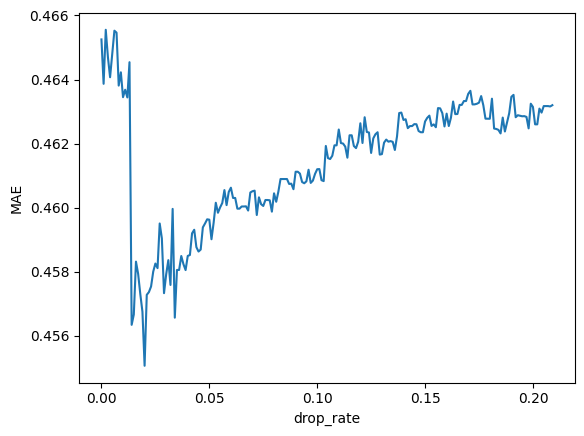

In [340]:
st = time.time()

param_grid = {
   'drop_rate': np.arange(0, 0.21, 0.001) 
}

grid_search = GridSearchCV(
    estimator=lgbm,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=5,
    verbose=1
)

grid_search.fit(G_val, ys_val)
end = time.time()

print('best params are', grid_search.best_params_)
print('best mae is', -grid_search.best_score_)
print('Time:', end-st)

results = grid_search.cv_results_
gamma = results['param_drop_rate']
mean_test_scores = -results['mean_test_score'] 

plt.plot(gamma, mean_test_scores)
plt.xlabel('drop_rate')
plt.ylabel('MAE')
# plt.title('MAE vs Gamma')

plt.savefig('rfr_figure_Folder/'+prop_tag+'_ag_rfr_dr.pdf')
plt.show()

In [345]:
st = time.time()

param_grid = {
    'min_child_samples': np.arange(1, 5),
#     'min_child_weight': [0.5, 0.1, 0.05, 0.01, 0.005, 0.001],
    'reg_lambda': np.arange(0.01, 0.21, 0.01),
    'drop_rate': np.arange(0.01, 0.11, 0.01) 
}

grid_search = GridSearchCV(
    estimator=lgbm,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=5,
    verbose=1
)

grid_search.fit(G_val, ys_val)
end = time.time()

print('best params are', grid_search.best_params_)
print('best mae is', -grid_search.best_score_)
print('Time:', end-st)

Fitting 5 folds for each of 800 candidates, totalling 4000 fits
best params are {'drop_rate': 0.09999999999999999, 'min_child_samples': 3, 'reg_lambda': 0.2}
best mae is 0.26751030329664505
Time: 145.38905239105225


In [ ]:
st = time.time()

param_grid = {
    'min_child_weight': [0.5, 0.1, 0.05, 0.01, 0.005, 0.001],
}

grid_search = GridSearchCV(
    estimator=lgbm,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=5,
    verbose=1
)

grid_search.fit(G_val, ys_val)
end = time.time()

print('best params are', grid_search.best_params_)
print('best mae is', -grid_search.best_score_)
print('Time:', end-st)

In [346]:
print('best params are', grid_search.best_params_)
print('best mae is', -grid_search.best_score_)

best params are {'drop_rate': 0.09999999999999999, 'min_child_samples': 3, 'reg_lambda': 0.2}
best mae is 0.26751030329664505


In [351]:
best_params = grid_search.best_params_
best_lgbm = lgb.LGBMRegressor(
    boosting_type = 'dart',
#     min_child_weight = 0.6,
    min_child_samples = 2,
    reg_lambda = 0.01,
    drop_rate = 0.01,
#     max_depth = 35,
#     feature_fraction= 0.97,
    verbose=-1
)

best_lgbm.fit(G_train, ys_train)

ys_pred_test = best_lgbm.predict(G_test)
y_pred_test = scaler_rf.inverse_transform(ys_pred_test.reshape(-1, 1)).reshape(ys_pred_test.size)

print('MAE', mean_absolute_error(y_test, y_pred_test))
print('R2 score', r2_score(y_test, y_pred_test))

MAE 41.27966171704247
R2 score 0.9537254575999526


In [353]:
ys_pred_train = best_lgbm.predict(G_train)
ys_pred_val = best_lgbm.predict(G_val)
ys_pred_all = best_lgbm.predict(G)
y_pred_train = scaler_rf.inverse_transform(ys_pred_train.reshape(-1, 1)).reshape(ys_pred_train.size)
y_pred_val = scaler_rf.inverse_transform(ys_pred_val.reshape(-1, 1)).reshape(ys_pred_val.size)
y_pred_all = scaler_rf.inverse_transform(ys_pred_all.reshape(-1, 1)).reshape(y.size)

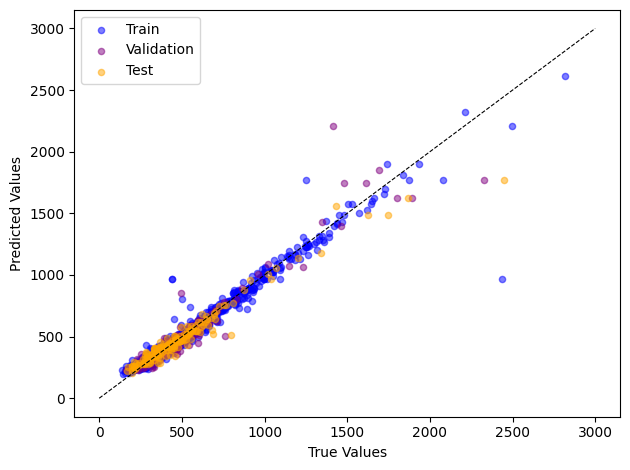

In [355]:
plt.scatter(y_train, y_pred_train, color='blue',s=20, alpha=0.5, label='Train')
plt.scatter(y_val, y_pred_val, color='purple', s=20, alpha=0.5, label='Validation')
plt.scatter(y_test, y_pred_test, color='orange',s=20, alpha=0.5, label='Test')

plt.plot([0, 3000], [0, 3000], color='black', linestyle='--',linewidth=0.8)

# plt.xlim(0, 100)
# plt.ylim(0, 100)

plt.legend(loc='upper left') 

plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.tight_layout()
plt.savefig('rfr_figure_Folder/'+prop_tag+'_all_groups_rfr_1.pdf')

plt.show()

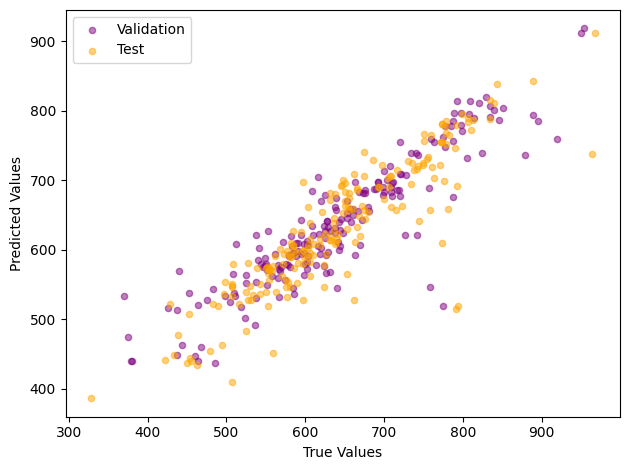

In [212]:
plt.scatter(y_val, y_pred_val, color='purple', s=20, alpha=0.5, label='Validation')
plt.scatter(y_test, y_pred_test, color='orange',s=20, alpha=0.5, label='Test')

# plt.plot([0, 500], [0, 500], color='black', linestyle='--',linewidth=0.8)

# plt.xlim(0, 100)
# plt.ylim(0, 100)

plt.legend(loc='upper left') 

plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.tight_layout()
plt.savefig('rfr_figure_Folder/'+prop_tag+'_all_groups_rfr_4.pdf')

plt.show()

In [213]:
result = []
for value in y_test:
    if value > 900:
        result.append(value)

print(result)

[967.59, 964.3]


In [356]:
print('MAE on train set',mean_absolute_error(y_train, y_pred_train))
print('R2 on train set',r2_score(y_train, y_pred_train))

MAE on train set 27.58498661014547
R2 on train set 0.9570722153714425


In [357]:
print('MAE on val set',mean_absolute_error(y_val, y_pred_val))
print('R2 on val set',r2_score(y_val, y_pred_val))

MAE on val set 45.06422757202921
R2 on val set 0.9113376901613433


In [358]:
print('MAE',mean_absolute_error(y, y_pred_all))
print('R2',r2_score(y, y_pred_all))

MAE 30.696358700027762
R2 0.9488799676189814


In [359]:
print('ARE on train set',np.average(np.abs((y_train - y_pred_train) / y_train))*100)
print('ARE on val set',np.average(np.abs((y_val - y_pred_val) / y_val))*100)
print('ARE on test set',np.average(np.abs((y_test - y_pred_test) / y_test))*100)

print('ARE ',np.average(np.abs((y - y_pred_all) / y))*100)

ARE on train set 6.519028331018493
ARE on val set 8.383761751514038
ARE on test set 9.040429298134267
ARE  6.957113126020002


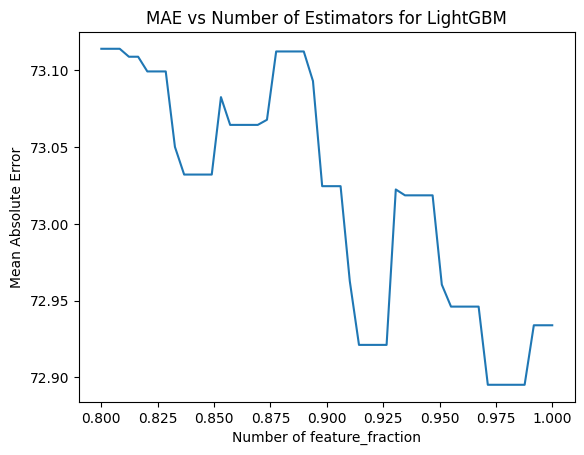

best feature_fraction is:0.9714285714285714


In [129]:
param_grid = {'feature_fraction': np.linspace(0.8, 1.0)}

grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, scoring='neg_mean_absolute_error', cv=5)

grid_search.fit(G_train, y_train)

results = grid_search.cv_results_
feature_fraction = results['param_feature_fraction']
mean_test_scores = -results['mean_test_score'] 

plt.plot(feature_fraction, mean_test_scores)
plt.xlabel('Number of feature_fraction')
plt.ylabel('Mean Absolute Error')
plt.title('MAE vs Number of Estimators for LightGBM')
plt.show()

best_feature_fraction = grid_search.best_params_['feature_fraction']
best_mae = -grid_search.best_score_
print('best feature_fraction is:' + str(best_feature_fraction))

In [360]:
import pickle

filename = f'tree_all_' + prop_tag + '.pkl'

saved_objects = {
    'model': best_lgbm,
    'scaler': scaler_rf
}

with open(filename, 'wb') as file:
    pickle.dump(saved_objects, file)

print(f'Model saved as {filename}')

Model saved as tree_all_Vc.pkl


ends here